**Import files**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn import svm
import csv
import cv2
import imageio

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageOps

In [2]:
image_filenames = [i for i in os.listdir('UTKFace/')] 

In [3]:
ages=[]
genders=[]
# Iterate throuigh the filenames and for each one load the image, resize and normalise
count = len(image_filenames)
images=[]
for i, image_file in enumerate(image_filenames):
        age=image_file.split('_')[0]
        gender=image_file.split('_')[1]
        image = imageio.imread('UTKFace/'+image_file)
        #Resizing images
        image = cv2.resize(image, (200,200), interpolation=cv2.INTER_CUBIC)        
        if i%10000==0:
            print('Processed {} of {} images'.format(i + 1, count))
        ages.append(int(age))
        genders.append(int(gender))
        images.append(image)

Processed 1 of 23708 images
Processed 10001 of 23708 images
Processed 20001 of 23708 images


**Add the data to DataFrame**

In [4]:
#Convert to series
images_list = pd.Series(list(images),name='Images')
ages_list = pd.Series(list(ages),name='Age')
#0 for Male 1 for Female
genders_list = pd.Series(list(genders),name='Gender')

df = pd.concat([images_list, ages_list, genders_list],axis=1)
df.head()

,Images,Age,Gender
0,"[[[215, 206, 201], [213, 204, 199], [212, 203,...",100,0
1,"[[[118, 122, 134], [120, 124, 135], [122, 126,...",100,0
2,"[[[221, 222, 226], [232, 235, 240], [232, 237,...",100,1
3,"[[[78, 82, 93], [78, 82, 93], [78, 82, 93], [7...",100,1
4,"[[[65, 69, 80], [66, 70, 81], [67, 71, 82], [6...",100,1


**Distribution of data**

C:\Users\MLPUser\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


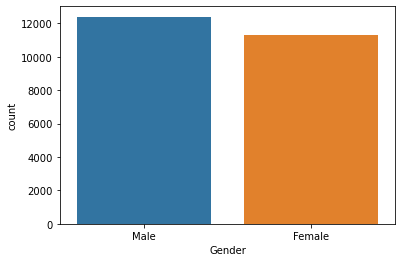

In [5]:
sns.countplot(df['Gender'])
labels = ["Male", "Female"]
plt.xticks(range(2),labels)
plt.show()

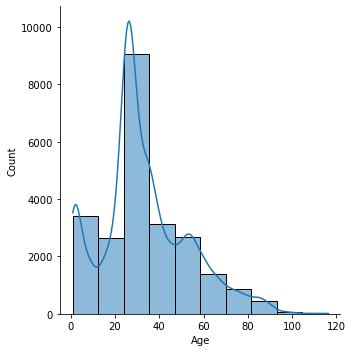

In [6]:
sns.displot(df['Age'],kde=True,bins=10)

In [7]:
df['Age'].value_counts().head(5)

26    2197
1     1123
28     918
35     880
24     859
Name: Age, dtype: int64

It is observed that the age group of 26 has high counts , the model can perform best for this age group ,hence we try to take a small sample out 

In [8]:
midtwentys = []

for i in range(len(df)):
    if df['Age'].iloc[i] == 26:
        midtwentys.append(df.iloc[i])
midtwentys = pd.DataFrame(midtwentys)
midtwentys = midtwentys.sample(frac=0.3)

In [9]:
len(midtwentys)

659

In [10]:
df = df[df['Age']!=26]
df = pd.concat([df, midtwentys], ignore_index = True)
df.shape

(22170, 3)

In [11]:
df['Age'].value_counts().head(5)

1     1123
28     918
35     880
24     859
25     734
Name: Age, dtype: int64

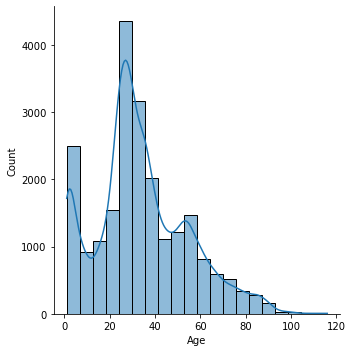

In [12]:
sns.displot(df['Age'],kde=True,bins=20)

We also see there is a large number of images with 1 year old babies. We can take a sample of those images.

In [13]:
ageone = []

for i in range(len(df)):
    if df['Age'].iloc[i] ==1:
        ageone.append(df.iloc[i])
ageone = pd.DataFrame(ageone)
ageone = ageone.sample(frac=0.4)
df = df[df['Age']!=1]
df = pd.concat([df, ageone], ignore_index = True)
df.shape

(21496, 3)

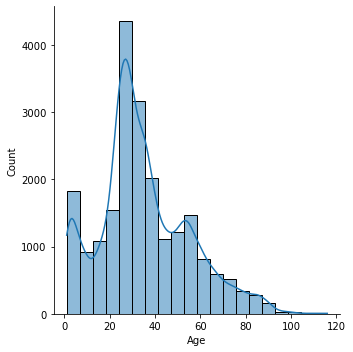

In [14]:
sns.displot(df['Age'],kde=True,bins=20)

**Storing images to an array**

In [15]:
X = []
for i in range(len(df)):
    img = np.asarray(df['Images'].iloc[i])
    X.append(img)
X = np.array(X)

**Train test split**

In [16]:
y_age = df['Age']
y_gender = df['Gender']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(X, y_age, test_size=0.2)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(X, y_gender, test_size=0.2)

In [17]:
y_gender.value_counts()

0    11314
1    10182
Name: Gender, dtype: int64

# Model Creation

**Creating model For Age**

In [18]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200,200, 3)))
agemodel.add(MaxPooling2D((2,2)))

agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))

agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))

agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
             optimizer='adam',metrics=['mae'])

In [19]:
agemodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 67712)             0

**Creating model for gender**

In [20]:
gender_model = Sequential()
gender_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(200,200, 3)))
gender_model.add(MaxPooling2D((2,2)))

gender_model.add(Conv2D(64, (3,3), activation='relu'))
gender_model.add(MaxPooling2D((2,2)))

gender_model.add(Conv2D(128, (3,3), activation='relu'))
gender_model.add(MaxPooling2D((2,2)))

gender_model.add(Flatten())
gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.5))

gender_model.add(Dense(1, activation='sigmoid'))

gender_model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

**Training Age Model**

In [20]:
datagen = ImageDataGenerator(rescale=1./255, width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(x_test_age, y_test_age,batch_size=32)

historyage = agemodel.fit(train1, epochs=40, shuffle=True, validation_data=test1)

Epoch 1/40
538/538 [==============================] - 285s 503ms/step - loss: 551.5412 - mae: 18.0468 - val_loss: 317.8879 - val_mae: 13.4795
Epoch 2/40
538/538 [==============================] - 305s 567ms/step - loss: 369.9819 - mae: 14.9203 - val_loss: 250.8355 - val_mae: 11.9234
Epoch 3/40
538/538 [==============================] - 322s 599ms/step - loss: 306.0519 - mae: 13.5624 - val_loss: 193.6079 - val_mae: 10.6899
Epoch 4/40
538/538 [==============================] - 282s 524ms/step - loss: 274.9688 - mae: 12.7191 - val_loss: 179.9665 - val_mae: 10.2057
Epoch 5/40
538/538 [==============================] - 293s 544ms/step - loss: 253.8085 - mae: 12.2500 - val_loss: 169.8459 - val_mae: 9.8406
Epoch 6/40
538/538 [==============================] - 297s 551ms/step - loss: 237.4701 - mae: 11.8359 - val_loss: 151.3352 - val_mae: 9.2540
Epoch 7/40
538/538 [==============================] - 285s 530ms/step - loss: 218.9846 - mae: 11.3710 - val_loss: 133.2984 - val_mae: 8.8303
Epoch 8/4

**Training Gender Model**

In [22]:
datagen = ImageDataGenerator(rescale = 1./255,width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(x_test_gender, y_test_gender,batch_size=64)

historygender = gender_model.fit(train2, epochs=30, shuffle=True, validation_data=test2)

Epoch 1/30
269/269 [==============================] - 282s 1s/step - loss: 0.7127 - accuracy: 0.6394 - val_loss: 0.4936 - val_accuracy: 0.7565
Epoch 2/30
269/269 [==============================] - 277s 1s/step - loss: 0.5005 - accuracy: 0.7607 - val_loss: 0.4059 - val_accuracy: 0.8177
Epoch 3/30
269/269 [==============================] - 277s 1s/step - loss: 0.4583 - accuracy: 0.7827 - val_loss: 0.3935 - val_accuracy: 0.8219
Epoch 4/30
269/269 [==============================] - 277s 1s/step - loss: 0.4335 - accuracy: 0.8041 - val_loss: 0.3480 - val_accuracy: 0.8456
Epoch 5/30
269/269 [==============================] - 276s 1s/step - loss: 0.4085 - accuracy: 0.8151 - val_loss: 0.3433 - val_accuracy: 0.8486
Epoch 6/30
269/269 [==============================] - 276s 1s/step - loss: 0.3840 - accuracy: 0.8293 - val_loss: 0.3318 - val_accuracy: 0.8560
Epoch 7/30
269/269 [==============================] - 276s 1s/step - loss: 0.3680 - accuracy: 0.8372 - val_loss: 0.3190 - val_accuracy: 0.8542

**Plotting accuracy and loss for gender model**

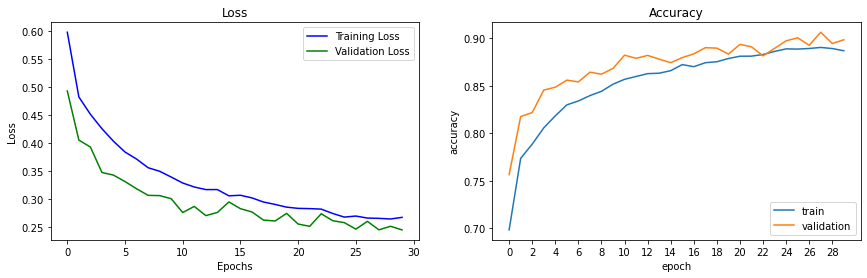

In [99]:
plt.subplots_adjust(left=None, bottom=None, right = 2, top=None, wspace=None, hspace=None)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
loss = historygender.history['loss']
val_loss = historygender.history['val_loss']
epochs=30
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2) # index 2
plt.plot(historygender.history['accuracy'])
plt.plot(historygender.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(0,epochs)[0::2])
plt.legend(['train', 'validation'], loc='lower right')

**Plotting loss and MAE for age model**

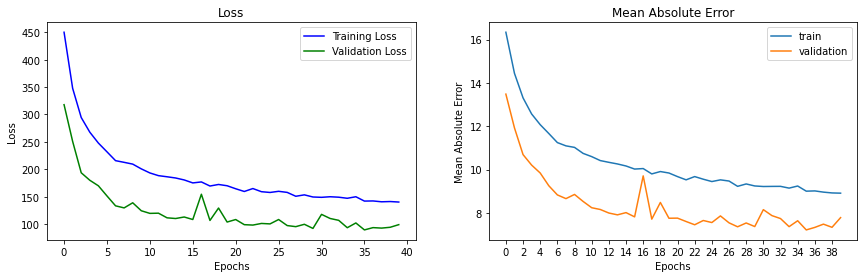

In [21]:
plt.subplots_adjust(left=None, bottom=None, right = 2, top=None, wspace=None, hspace=None)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
loss = historyage.history['loss']
val_loss = historyage.history['val_loss']
epochs=40
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2) # index 2
plt.plot(historyage.history['mae'])
plt.plot(historyage.history['val_mae'])
plt.title('Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.xticks(range(0,epochs)[0::2])
plt.legend(['train', 'validation'], loc='upper right')

In [26]:
import tensorflow as tf
from keras.models import load_model

gender_model.save('gender_model.h5')
agemodel.save('age_model.h5')

**Evaluation of Gender Model**

In [72]:
y_pred_gender = gender_model.predict(x_test_gender)

In [79]:
y_pred_gender =np.round(y_pred_gender)

0.851955484475252


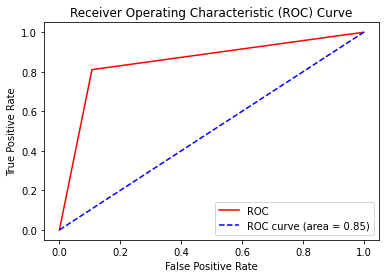

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test_gender, y_pred_gender)
auc = roc_auc_score(y_test_gender, y_pred_gender)
print(auc)


plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [85]:
from sklearn.metrics import classification_report
#0 -Male 1-Female
print(classification_report(y_test_gender, y_pred_gender,target_names=['Male','Female']))

              precision    recall  f1-score   support

        Male       0.84      0.89      0.87      2291
      Female       0.87      0.81      0.84      2009

    accuracy                           0.85      4300
   macro avg       0.86      0.85      0.85      4300
weighted avg       0.86      0.85      0.85      4300



<ipython-input-89-56e71942abb3>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


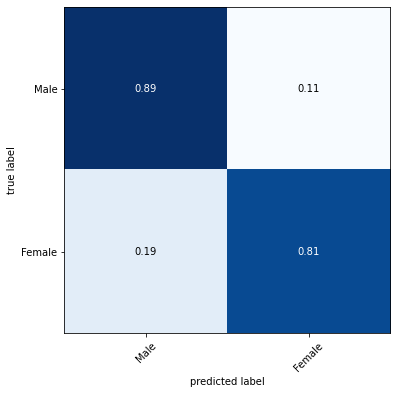

In [89]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_gender, y_pred_gender)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,show_normed=True,
                                show_absolute=False,
                                class_names=['Male','Female'],
                                figsize=(6, 6))
fig.show()

In [93]:
TN, FP,FN, TP = confusion_matrix(y_test_gender, y_pred_gender).ravel()

In [94]:
(TN, FP,FN, TP)

(2046, 245, 380, 1629)

In [104]:
accuracy = (TP+TN)/(TP+FP+FN+TN)
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
print('Accuracy %=',np.round(accuracy,2)*100)
print('True Positive Rate %=',np.round(TPR,2)*100)
print('False Positive Rate %=',np.round(FPR,2)*100)

Accuracy %= 85.0
True Positive Rate %= 81.0
False Positive Rate %= 11.0


**Evaluation for age model**

In [22]:
y_pred_age=[]

In [23]:
for i in x_test_age:
    i=i/255
    i=i.reshape(-1,200,200,3)
    y_pred_age.append(int(agemodel.predict(i)))

In [24]:
y_pred_age=np.asarray(y_pred_age).astype(int)

In [25]:
y_pred_age

array([40, 73, 26, ..., 44, 26, 88])

In [44]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
mse = mean_squared_error(y_test_age, y_pred_age)
rmse = mean_squared_error(y_test_age, y_pred_age,squared=False)
mae= mean_absolute_error(y_test_age, y_pred_age)
print('MSE=',np.round(mse,2))
print('RMSE=',rmse)
print('Mean Absolute Error',mae)

MSE= 96.73
RMSE= 9.834916440689714
Mean Absolute Error 7.662790697674419


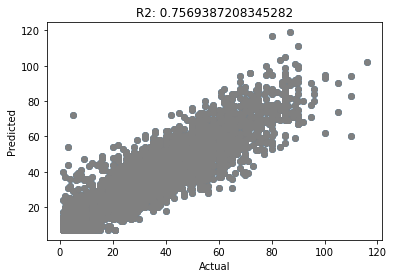

In [39]:
fig, ax = plt.subplots()
ax.scatter(y_test_age,y_pred_age)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.scatter(y_test_age,y_pred_age,color='gray')
ax.set_title('R2: ' + str(r2_score(y_test_age,y_pred_age)))
plt.show()